In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


# Load the CSV file
file_path = './rawdata/1_1.csv'
df = pd.read_csv(file_path)
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])
    
# Identify continuous variables (numeric columns) excluding binary and categorical variables
continuous_vars = df.select_dtypes(include=['float64', 'int64']).columns
binary_vars = [col for col in continuous_vars if df[col].nunique() == 2]
categorical_vars = [col for col in continuous_vars if df[col].nunique() <= 10 and col not in binary_vars]
continuous_vars = [col for col in continuous_vars if col not in binary_vars and col not in categorical_vars]

# Initialize the StandardScaler
scaler = MinMaxScaler()

# Apply StandardScaler to continuous variables
df[continuous_vars] = scaler.fit_transform(df[continuous_vars])

# Save the scaled dataframe to a new CSV file
scaled_file_path = './MinMax.csv'
df.to_csv(scaled_file_path, index=False)

# Display the first few rows of the scaled dataframe
print(df.shape)


(1700, 73)


Accuracy with MinMax scaling: 0.8794117647058823
Accuracy with Standard scaling: 0.8794117647058823
F1 Macro with MinMax scaling: 0.21857103319069215
F1 Micro with MinMax scaling: 0.8794117647058823
F1 Macro with Standard scaling: 0.21857103319069215
F1 Micro with Standard scaling: 0.8794117647058823
AUC with MinMax scaling: 0.8222273584087223
AUC with Standard scaling: 0.8222273584087223


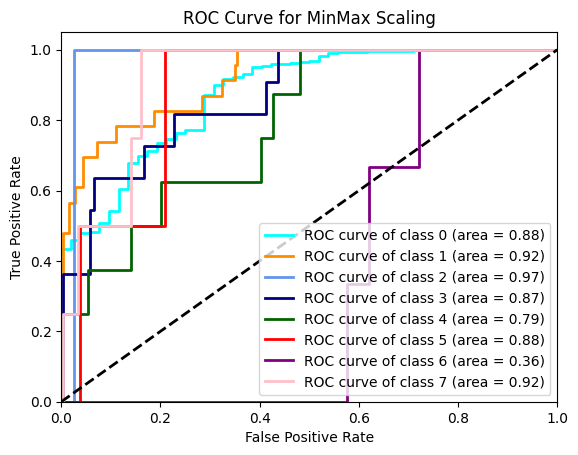

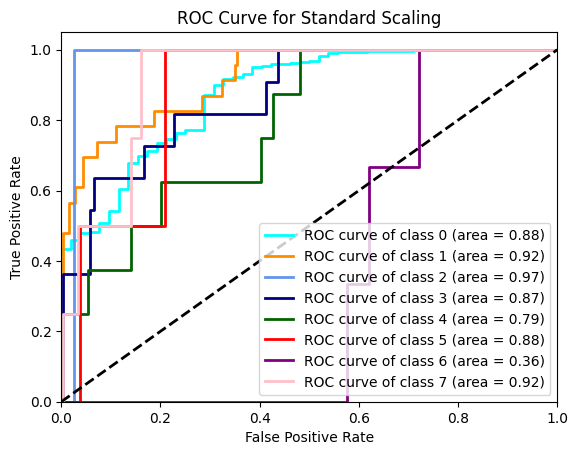

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Load the datasets
minmax_df = pd.read_csv('./MinMax.csv')
standard_df = pd.read_csv('./standard.csv')
target_df = pd.read_csv('./rawdata/target.csv')

# Drop unnecessary columns
if 'Unnamed: 0' in minmax_df.columns:
    minmax_df = minmax_df.drop(columns=['Unnamed: 0'])

if 'Unnamed: 0' in standard_df.columns:
    standard_df = standard_df.drop(columns=['Unnamed: 0'])

# Extract the target variable
y = target_df['LET_IS']
classes = sorted(y.unique())

# Binarize the output for multi-class AUC calculation
y_bin = label_binarize(y, classes=classes)

# Split the data into training and testing sets for MinMax scaled data
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(minmax_df, y, test_size=0.2, random_state=42)

# Split the data into training and testing sets for Standard scaled data
X_train_standard, X_test_standard, y_train_standard, y_test_standard = train_test_split(standard_df, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model for MinMax scaled data
model_minmax = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_minmax.fit(X_train_minmax, y_train_minmax)

# Initialize and train the XGBoost model for Standard scaled data
model_standard = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_standard.fit(X_train_standard, y_train_standard)

# Make predictions
y_pred_minmax = model_minmax.predict(X_test_minmax)
y_pred_standard = model_standard.predict(X_test_standard)

# Calculate accuracy
accuracy_minmax = accuracy_score(y_test_minmax, y_pred_minmax)
accuracy_standard = accuracy_score(y_test_standard, y_pred_standard)

# Calculate F1 scores
f1_macro_minmax = f1_score(y_test_minmax, y_pred_minmax, average='macro')
f1_micro_minmax = f1_score(y_test_minmax, y_pred_minmax, average='micro')
f1_macro_standard = f1_score(y_test_standard, y_pred_standard, average='macro')
f1_micro_standard = f1_score(y_test_standard, y_pred_standard, average='micro')

# Calculate AUC scores
y_test_minmax_bin = label_binarize(y_test_minmax, classes=classes)
y_test_standard_bin = label_binarize(y_test_standard, classes=classes)

y_pred_minmax_proba = model_minmax.predict_proba(X_test_minmax)
y_pred_standard_proba = model_standard.predict_proba(X_test_standard)

auc_minmax = roc_auc_score(y_test_minmax_bin, y_pred_minmax_proba, average='macro', multi_class='ovr')
auc_standard = roc_auc_score(y_test_standard_bin, y_pred_standard_proba, average='macro', multi_class='ovr')

# Print scores
print(f"Accuracy with MinMax scaling: {accuracy_minmax}")
print(f"Accuracy with Standard scaling: {accuracy_standard}")
print(f"F1 Macro with MinMax scaling: {f1_macro_minmax}")
print(f"F1 Micro with MinMax scaling: {f1_micro_minmax}")
print(f"F1 Macro with Standard scaling: {f1_macro_standard}")
print(f"F1 Micro with Standard scaling: {f1_micro_standard}")
print(f"AUC with MinMax scaling: {auc_minmax}")
print(f"AUC with Standard scaling: {auc_standard}")

# Plot ROC curves
fpr_minmax = dict()
tpr_minmax = dict()
roc_auc_minmax = dict()

fpr_standard = dict()
tpr_standard = dict()
roc_auc_standard = dict()

for i in range(len(classes)):
    fpr_minmax[i], tpr_minmax[i], _ = roc_curve(y_test_minmax_bin[:, i], y_pred_minmax_proba[:, i])
    roc_auc_minmax[i] = auc(fpr_minmax[i], tpr_minmax[i])

    fpr_standard[i], tpr_standard[i], _ = roc_curve(y_test_standard_bin[:, i], y_pred_standard_proba[:, i])
    roc_auc_standard[i] = auc(fpr_standard[i], tpr_standard[i])

# Plot ROC curve for MinMax scaling
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'darkgreen', 'red', 'purple', 'pink'])
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr_minmax[i], tpr_minmax[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc_minmax[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MinMax Scaling')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for Standard scaling
plt.figure()
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr_standard[i], tpr_standard[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc_standard[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Standard Scaling')
plt.legend(loc="lower right")
plt.show()
